# Quantitative STEM analysis

**Roberto dos Reis**<br>
Northwestern University

## Packages needed:
* [h5py](http://docs.h5py.org/en/stable/index.html) - To install use: ``conda install h5py``
* [pyStackReg](https://pystackreg.readthedocs.io/en/latest/) - To install use: ``pip install pystackreg``


We will use EMD format in the beginning of the lecture<br>
Learn more about [emd format](https://emdatasets.com/format/)


**References for images used in this notebook:** <br>
R. dos Reis <i>et al</i> Appl. Phys. Lett. 102, 081905 (2013); https://doi.org/10.1063/1.4793651 <br>
B. Jany <i>et al</i> Micron 130, 102800 (2020); https://doi.org/10.1016/j.micron.2019.102800 <br>


### Load necessary packages:

In [1]:
# Numeric operations
import numpy as np

# Visualization / Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

#for emd read/write
import h5py
import datetime
from pathlib import Path


# Scientific image processing library:
import skimage
if int(skimage.__version__.split('.')[1]) < 14:
    from warnings import warn
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version'.format(skimage.__version__))
from skimage import io
from skimage import filters
from skimage.morphology import disk
from skimage.feature import blob_log


#for scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


# Ensure that images are rendered in this notebook:
%matplotlib inline

## Reading images

We wil be using ``h5py`` to read h5 file here.

Alternatively, you can use ``ncempy`` to read dm* or .ser files or ``skimage.io.imread()`` for .tif

In [44]:
# Alternative ways to read the images

# stem_image = io.imread('***.tif')

# from ncempy.io import dm
# im0 = dm.dmReader('***.dm3')
# stem_image = im0['data'] 

# to read .ser
import ncempy.io as nio
with nio.ser.fileSER('images/GaAs_02.ser') as ser1:
    stem_image, metadata = ser1.getDataset(0)
    
# Normalizing image here:
stem_image = skimage.img_as_float(stem_image)

# getting the calibration
calibration = metadata['Calibration'][0]['CalibrationDelta']

In [45]:
metadata

{'Calibration': ({'CalibrationOffset': -3.306760208299439e-09,
   'CalibrationDelta': 3.2292580159174207e-12,
   'CalibrationElement': 0},
  {'CalibrationOffset': -3.306760208299439e-09,
   'CalibrationDelta': 3.2292580159174207e-12,
   'CalibrationElement': 0}),
 'DataType': 2,
 'ArrayShape': [2048, 2048]}

### Creating a .h5 file from current image

1. EMD/HDF files consist of two types of objects:<br>
a. **Datasets:** multidimensional arrays <br>
b. **Groups:** groups consist of datasets or other groups

Multidimensional arrays of any size and type can be stored as a dataset, but the dimensions and type have to be uniform within a dataset. Each dataset must contain a homogeneous N-dimensional array. That said, because groups and datasets may be nested, you can still get the heterogeneity you may need:

In [5]:
# # create file
# f = h5py.File('images/GaAs_IDB_1.emd', 'w')

# # set version information
# f.attrs['version_major'] = 0
# f.attrs['version_minor'] = 2

# # add a group
# grp_exp = f.create_group('data')

# # add an emd type subgroup for the dataset
# grp_dst = grp_exp.create_group('dataset_1')
# grp_dst.attrs['emd_group_type'] = 1

# # create a 3D dataset with random floats
# data = grp_dst.create_dataset('data', (stem_image.shape[0],stem_image.shape[1]), dtype='float')
# data[:,:] = stem_image

# # add dimension vectors
# dim1 = grp_dst.create_dataset('dim1', (stem_image.shape[0],1), dtype='int')
# dim1[:,0] = np.array(range(stem_image.shape[0]))
# dim1.attrs['name'] = np.string_('x')
# dim1.attrs['units'] = np.string_('[px]')

# dim2 = grp_dst.create_dataset('dim2', (stem_image.shape[0],1), dtype='int')
# dim2[:,0] = np.array(range(stem_image.shape[0]))
# dim2.attrs['name'] = np.string_('y')
# dim2.attrs['units'] = np.string_('[px]')
 
# # dim3 = grp_dst.create_dataset('dim3', (1,1), dtype='float')
# # # dim3[:,0] = np.linspace(0.0, 3.14, num=100)
# # dim3 = np.asarray(calibration).astype(np.float64)
# # dim3.attrs['name'] = np.string_('image calibration')
# # dim3.attrs['units'] = np.string_('[pixel/m]')


# # create microscope group for metadata
# grp_mic = f.create_group('microscope')
# grp_mic.attrs['magnification'] = 10
# grp_mic.attrs['calibration'] = calibration
# grp_mic.attrs['units'] = 'm'


# # create user group for user info
# grp_usr = f.create_group('user')
# grp_usr.attrs['operator'] = np.string_('RdR')
# grp_usr.attrs['email'] = np.string_('roberto.reis@northwestern.edu')


# # create sample group for information on sample
# grp_spl = f.create_group('sample')
# grp_spl.attrs['material'] = np.string_('Gallium Arsenide')

# # create comments group for log
# grp_com = f.create_group('comments')
 
# # add a comment on file creation with the current timestamp
# timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S (UTC)')
# grp_com.attrs[timestamp] = np.string_('HR-STEM image for AdvancedEM course')

# # close the file
# f.close()

### Reading emd

In [6]:
# open the EMD file
f = h5py.File('images/GaAs_IDB_1.emd', 'r')
 
# assuming you know the structure of the file
emdgrp = f['data/dataset_1']

# read data
data = emdgrp['data'][:]

grp_mic = f['microscope']
calibration = f['microscope'].attrs['calibration']
print('Calibration = {} in px/m'.format(calibration))


# getting user information
grp_usr = f['user']
email = f['user'].attrs['email'].decode('utf-8')
print('In case of questions, let\'s ask!! {}'.format(email))

# close the EMD file
f.close()

Calibration = 3.2292580159174207e-12 in px/m
In case of questions, let's ask!! roberto.reis@northwestern.edu


**Filtering** 
- You can find few options for filtering in [week 1 material](https://github.com/rmsreis/AdvancedEM/blob/master/Week1/01_Image_Processing.ipynb)

In [7]:
# Here, I applied the median filter (my favorite!)

stem_filtered = filters.median(data, disk(3))

In [43]:
calibration

41.20724346076459

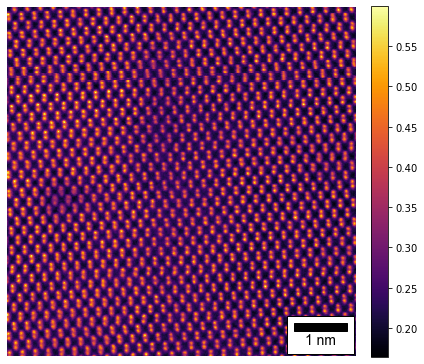

Fig 1: HAADF image from GaAs viewed along [110] direction


In [9]:
fig, axis = plt.subplots(figsize=(6,6))
im_handle = axis.imshow(stem_filtered, cmap=plt.cm.inferno)

barsize = 1e-09/calibration
fontprops = fm.FontProperties(size=14, family='Arial') #for scale bar

#Adding Scale Bar
scalebar = AnchoredSizeBar(axis.transData,
                           barsize, '1 nm', 'lower right', 
                           pad=0.5,
                           color='black',frameon=True,
                           size_vertical=50,
                           fontproperties=fontprops)

axis.add_artist(scalebar)
axis.axis('off')

# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()


print('Fig 1: HAADF image from GaAs viewed along [110] direction')

## STEM quantification:<br>
1. Identifying atomic species/intensity -- HRSTEM of GaAs IDB

To find areas of high intensity (a.k.a. atom columns), first we will use [Blob_Log](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html) method in skimage.

Blobs are found using the Laplacian of Gaussian (LoG) method [1](https://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian). 

For each blob found, the method returns its coordinates and the standard deviation of the Gaussian kernel that detected the blob.



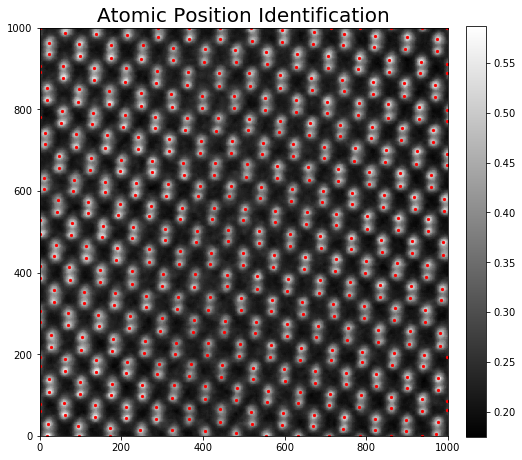

In [12]:
# Back to the STEM image
# cropped_image and median filtered

cropped_image = stem_filtered[500:1500,500:1500]

result_stem = blob_log(cropped_image, min_sigma=5.6, max_sigma=100, 
                  num_sigma=1, threshold=0.01) # modify treshold to refine your search

fig, axis = plt.subplots(figsize=(8, 8))
im_handle = axis.imshow(cropped_image, cmap='gray')
axis.scatter(result_stem[:, 1], result_stem[:, 0], s=5, c='r')
axis.set_xlim(left=0, right=cropped_image.shape[0])
axis.set_ylim(bottom=0, top=cropped_image.shape[1]);

# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('Atomic Position Identification', fontSize = 20);

In [14]:
result_stem.shape

(511, 3)

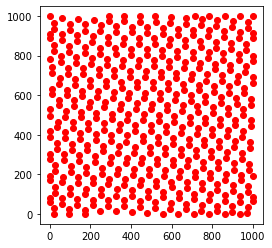

In [15]:
fig, axis = plt.subplots(figsize=(4, 4))
im_handle = axis.scatter(result_stem[:,1],result_stem[:,0], color='r')

plt.show()

To find each blob's radius, we have to multiply its sigma value by sqrt(2) <br>
**Remember:** ``blob_log`` returns x,y coordinates and a sigma value of the gaussian kernel

In [16]:
result_stem[:, 2] = result_stem[:, 2] * np.sqrt(2)

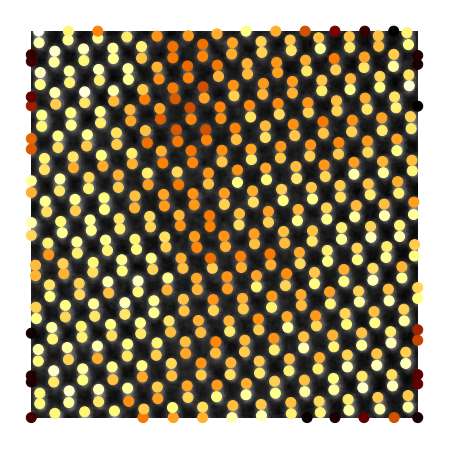

In [17]:
# Generate all row and column coordinates for our test image
# For an `(N, M)` test image, `ixs` will have shape `(N, M, 2)`,
# since it stores row and column coordinates.
ixs = np.indices(cropped_image.shape)

# Now, we plot each detected blob and estimate its average intensity

fig, axis = plt.subplots(figsize=(8, 8))
im_handle = axis.imshow(cropped_image, cmap='gray')
z=[]
x0=[]
y0=[]

for i, blob in enumerate(result_stem):
        y, x, r = blob
        # Define an array of, containing the center of the blob
        center = np.array([y, x])[:, np.newaxis, np.newaxis]
        
        # Using the formula for a circle, `x**2 + y**2 < r**2`, generate a mask for this blob.
        mask = ((ixs - center)**2).sum(axis=0) < r**2

        # Calculate the average intensity of pixels under the mask
        intensity = cropped_image[mask].mean()
        z.append(intensity)
        x0.append(x)
        y0.append(y)
        
        
x0 = np.array(x0)
y0 = np.array(y0)
z = np.array(z)

axis.scatter(x0,y0,c=z**2,s=100, cmap=plt.cm.afmhot)

axis.axis('off')

plt.show()

## Extra content

### Fitting a 2D gaussian - Optimizing the positions
There are doferrent ways o perform a more robust gaussian fiting 2D, for example by 
calculating the moments of the data to guess the initial parameters and runs a optimization routine.

Iterested to know more details? visit this [link](https://scipy-cookbook.readthedocs.io/items/FittingData.html)

There are many papers showing refinements at picometer precision, here are some of them [[1]](https://ascimaging.springeropen.com/articles/10.1186/s40679-017-0042-5),[[2]](https://link.springer.com/article/10.1186/s40679-020-0068-y),[[3]](https://www.sciencedirect.com/science/article/pii/S0304399116301747?via%3Dihub)

## STEM quantification:<br>
1. Atomically resolved HAADF STEM Image of nanoisland made of Au fcc and Au hcp phase

Here we will use a moving window that extracts local 2D FFT for classification of the grains

In [18]:
# Reading the image here:
hrstem = io.imread('images/STEM-HAADF-Aufcc-Auhcp.tif')

#The image width is equal to 49.7 nm
calibration = (hrstem.shape[1]/49.7) # pixels per nm

hrstem = skimage.img_as_float(hrstem)

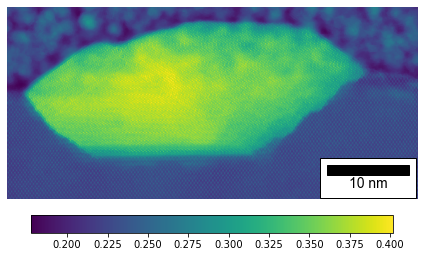

In [19]:

hrstem_filtered = filters.median(hrstem, disk(5))

fig, axis = plt.subplots(figsize=(6,6))
im_handle = axis.imshow(hrstem_filtered, cmap=plt.cm.viridis)

barsize = 10*calibration
fontprops = fm.FontProperties(size=14, family='Arial') #for scale bar


#Adding Scale Bar
scalebar = AnchoredSizeBar(axis.transData,
                           barsize, '10 nm', 'lower right', 
                           pad=0.5,
                           color='black',frameon=True,
                           size_vertical=50,
                           fontproperties=fontprops)

axis.add_artist(scalebar)
axis.axis('off')



# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04, orientation="horizontal")

fig.tight_layout()
plt.show()

### Sliding window over an image to extract local Fourier modes.
    
The ``as_strided()`` method in numpy takes an array, a shape, and strides as arguments. 
It creates a new array, but uses the same data buffer as the original array. The only thing that changes is the metadata. This trick lets us manipulate NumPy arrays as usual, except that they may take much less memory

In [26]:
from numpy.lib.stride_tricks import as_strided

In [27]:
elementsize = 128 
xstep = 64 #64 default for ~2000x2000 pixels image
ystep = 64 #64 default for ~2000x2000 pixels image

NComponents = "auto" #automatically determine number of components for NMF decomposition from PCA Scree Plot

im = hrstem_filtered

In [28]:
# shape of the elements on which you want to perform the operation (e.g. Fourier Transform)
ws = np.arange(elementsize*elementsize).reshape(elementsize, elementsize) 

In [29]:
imW = as_strided(im, shape=(int((im.shape[0]-ws.shape[0]+1)/xstep),int((im.shape[1]-ws.shape[1]+1)/ystep),
                                    ws.shape[0],ws.shape[1]), 
                     strides=(im.strides[0]*xstep,im.strides[1]*ystep,im.strides[0],im.strides[1]))

### Hanning Window Power Spectrum (FFT) from Local Window Data

More about window function [here](https://en.wikipedia.org/wiki/Window_function)


In [30]:
hanningf = np.hanning(elementsize)
hanningWindow2d = np.sqrt(np.outer(hanningf, hanningf))

imW_fft = np.fft.fftshift(np.abs(np.fft.fft2(hanningWindow2d*imW))**2, axes=(2,3))
imW_fft = np.log10(np.abs(imW_fft))

imW_fft.shape

(13, 30, 128, 128)

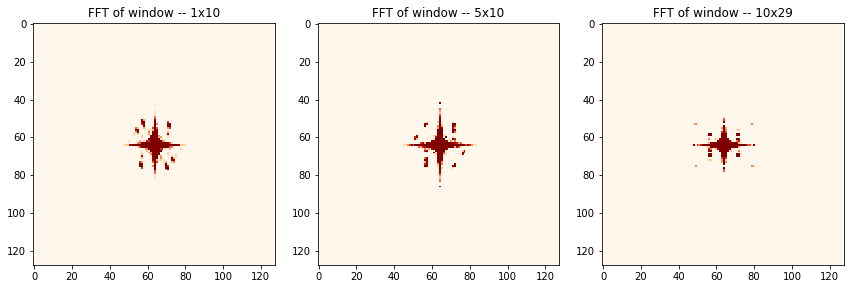

Here we see at least 3 different unique directions in the FFT that can be used for classification of the regions


In [31]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
im_handle = ax[0].imshow(imW_fft[1,10,:,:], cmap=plt.cm.OrRd, vmin=[0.35, 1])
ax[0].set_title('FFT of window -- 1x10')

im_handle = ax[1].imshow(imW_fft[5,10,:,:], cmap=plt.cm.OrRd, vmin=[0.35, 1])
ax[1].set_title('FFT of window -- 5x10')
    
im_handle = ax[2].imshow(imW_fft[10,29,:,:], cmap=plt.cm.OrRd, vmin=[0.35, 1])
ax[2].set_title('FFT of window -- 10x29')

fig.tight_layout()
plt.show()

print('Here we see at least 3 different unique directions in the FFT that can be used for classification of the regions')

### Reading image stacks/videos

- The code below demonstrates a quick way to read a image stack and align using ``pystackreg``

pyStackReg provides the following 4 types of distortions

1. Translation
2. Rigid body (translation + rotation)
3. Scaled rotation (translation + rotation + scaling)
4. Affine (translation + rotation + scaling + shearing)
5. Bilinear (non-linear transformation)

More information in the [pyStackReg documentation](https://pystackreg.readthedocs.io/en/latest/)

In [32]:
#to install
!pip install pystackreg

In [33]:
from pystackreg import StackReg
from skimage import io

# Reading myStack data 

from ncempy.io import dm
im0 = dm.dmReader('images/FocalSeries_Example.dm3')
myStack = im0['data']

#Alternatively:
#imgStack = io.imread('some_multiframe_image.tif') # 3 dimensions : frames x width x height

In [34]:
myStack.shape

(20, 512, 512)

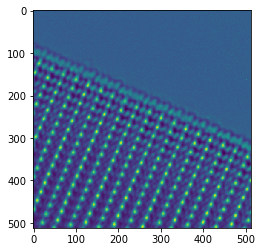

In [37]:
plt.imshow(myStack[0,:,:])
plt.show()

In [30]:
### Plotting sum of the stack + fft

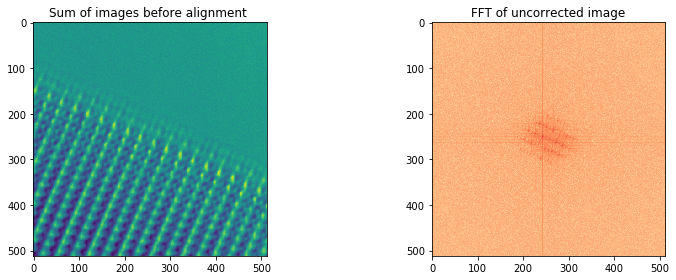

In [36]:
stack_sum = np.sum(myStack, axis=0)
fft_raw = np.fft.fftshift(np.fft.fft2(stack_sum))


fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
im_handle = axes[0].imshow(stack_sum)
axes[0].set_title('Sum of images before alignment ')

im_handle = axes[1].imshow(np.log10(abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[2, 12])
axes[1].set_title('FFT of uncorrected image')

fig.tight_layout()


In [39]:
sr = StackReg(StackReg.RIGID_BODY)

# register each frame to the previous (already registered)
# stack_previous = sr.register_transform_stack(img0, reference='previous')

# register to first image
stack_first = sr.register_transform_stack(myStack, reference='first')

# register to mean image
# stack_mean = sr.register_transform_stack(img0, reference='mean')

# register to mean of first 10 images
# stack_first10 = sr.register_transform_stack(img0, reference='first', n_frames=10)

# calculate a moving average of 10 images, then register the moving average to the mean of
# the first 10 images and transform the original image (not the moving average)

# stack_moving10 = sr.register_transform_stack(img0, reference='first', n_frames=10, moving_average = 10)

In [40]:
stack_first.shape

(20, 512, 512)

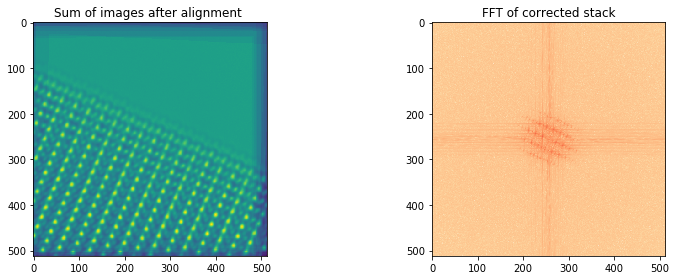

In [41]:
stack_first_sum = np.sum(stack_first, axis=0)
fft_corrected = np.fft.fftshift(np.fft.fft2(stack_first_sum))


fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
im_handle = axes[0].imshow(stack_first_sum)
axes[0].set_title('Sum of images after alignment ')

im_handle = axes[1].imshow(np.log10(abs(fft_corrected)), cmap=plt.cm.OrRd, vmin=[2, 14])
axes[1].set_title('FFT of corrected stack')

fig.tight_layout()


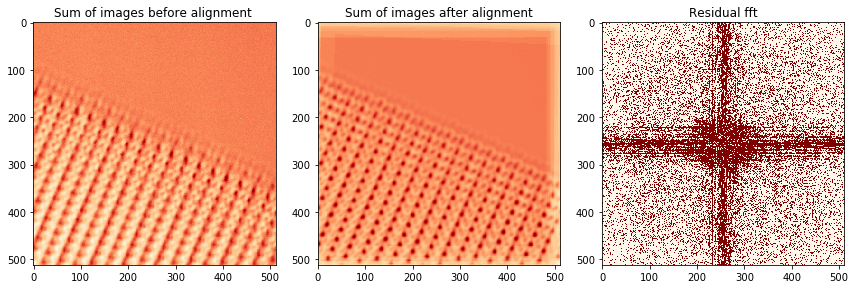

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

im_handle = axes[0].imshow(stack_sum, cmap=plt.cm.OrRd,)
axes[0].set_title('Sum of images before alignment ')

im_handle = axes[1].imshow(stack_first_sum, cmap=plt.cm.OrRd,)
axes[1].set_title('Sum of images after alignment')

im_handle = axes[2].imshow((abs(fft_corrected) - abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[2, 12])
axes[2].set_title('Residual fft')

fig.tight_layout()